## Notebook used to make synthetic disease progressions for healthy, LIR & MIR subgroups

In [29]:
# load packages and files
using DifferentialEquations, SciMLBase, Plots, Random # for solving ODEs
using DataFrames
using DataStructures # for the OrderedDict
using LatinHypercubeSampling # for the LHS
using Trapz # for the trapezoidal rule
using CSV # for reading in the parameter distributions of the Ohashi
using Statistics # for the mean and std functions
using JLD2 # for saving the results
Random.seed!(1234)

include("../EDES/including.jl") # for the EDES model 
include("../DataGeneration/AnalyseSynths/SyntheticPatients.jl") # for generating initial states of the synthetic patients
include("../DataGeneration/AnalyseSynths/LocalSensitivity.jl") # for the local sensitivity analysis
include("MIRLIR_progression.jl") # for the MIRLIR disease trajectories
include("../DataGeneration/AnalyseSynths/Realism_inital.jl") # for the analysis of the synthetic patients


ensure_realism_initial (generic function with 3 methods)

In [17]:
# hyperparameters for the data generation
N = 30 # number of patients
BW = 70 
spread_percentage = 0.15

# initial parameters for the synthetic population
distributions_ohashi = CSV.read("./accepted_df_allOHASHI.csv", DataFrame)
initial_k1 = mean(distributions_ohashi[!, "k1"])
initial_k5 = mean(distributions_ohashi[!, "k5"])
initial_k6 = mean(distributions_ohashi[!, "k6"])
# initial_k5 = 0.112
# initial_k6 = 2.03
# initial_k4 = 2.35e-4
# initial_G_liv_b = 0.043
parameter_names = ["k1","k5", "k6"]
initial_people = [initial_k1, initial_k5, initial_k6]
fasting_range_glucose = (4.8, 5.2)
fasting_range_insulin = (7.5, 12.0)

# standard deviations for the parameters, right now
lower_deviations_initial = initial_people .- (initial_people .* spread_percentage )
upper_deviations_initial = initial_people .+ (initial_people .* spread_percentage )


parameter_ranges_initial= OrderedDict( "k1" => (lower_deviations_initial[1], upper_deviations_initial[1]),
                                    "k5" => (lower_deviations_initial[2], upper_deviations_initial[2]),
                                    "k6" => (lower_deviations_initial[3], upper_deviations_initial[3]),
                                   )
fasting_ranges = OrderedDict("fasting_glucose" => fasting_range_glucose, "fasting_insulin" => fasting_range_insulin)


Synthetic_population_healthy = MakePatients(N, parameter_names, parameter_ranges_initial, fasting_ranges, BW = BW);

Check realism for the meal responses of all the initial patients 

In [18]:
boolean_vector = []
for i in 1:length(Synthetic_population_healthy)
    synthetic_patient = Synthetic_population_healthy[i]
    result = ensure_realism_initial(synthetic_patient)
    push!(boolean_vector, result)
end

boolean_vector

insulin must be decreasing after 3 hours
insulin must be decreasing after 3 hours
insulin must be decreasing after 3 hours
insulin must be decreasing after 3 hours
insulin must be decreasing after 3 hours
insulin must be decreasing after 3 hours
insulin must be decreasing after 3 hours
insulin must be decreasing after 3 hours
insulin must be decreasing after 3 hours
insulin must be decreasing after 3 hours
insulin must be decreasing after 3 hours
insulin must be decreasing after 3 hours
Glucose dip should not get too low (not more than 20% below fasting value)


30-element Vector{Any}:
  true
 false
  true
  true
 false
 false
  true
 false
 false
 false
     ⋮
  true
  true
  true
  true
 false
 false
  true
  true
  true

#### visualise OGTT response

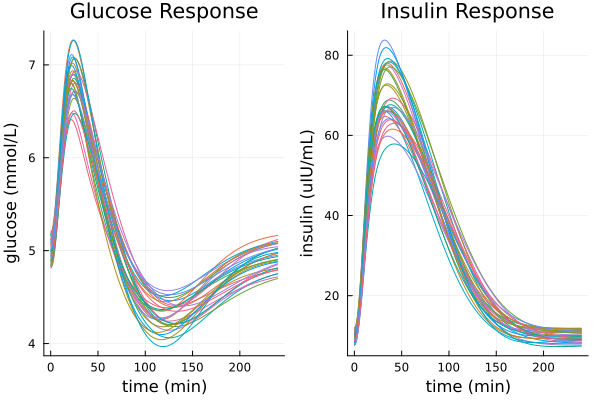

In [19]:
# Assuming Synthetic_population_healthy is a vector of EDES models
# and ParameterValues is a vector of parameter vectors for each patient
glucose_output = PlotMealResponse(
    [Synthetic_population_healthy[i].EDES for i in 1:length(Synthetic_population_healthy)],
    [Synthetic_population_healthy[i].ParameterValues for i in 1:length(Synthetic_population_healthy)]
)

#### Get metabolic values at specific timepoints

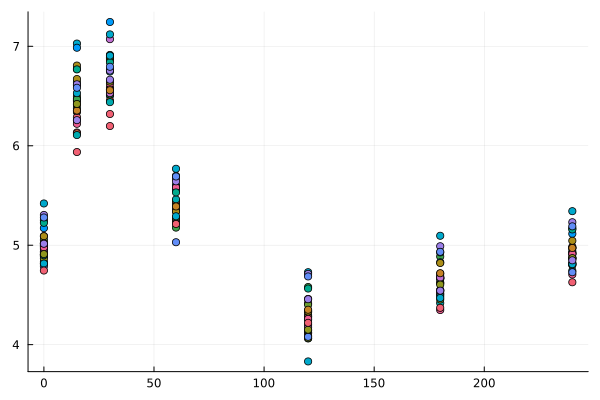

In [20]:
# select timepoints for the output 
timepoints = [0, 15, 30, 60, 120, 180, 240]
variation_G = 0.05
variation_I = 0.10

# get the time 
metabolic_values = [SelectTimePoints(patient, time_points_G = timepoints, time_points_I = timepoints,  variation_G = variation_G,  variation_I = variation_I ) for patient in Synthetic_population_healthy]

figure_glucose = plot()
figure_insulin = plot()
for i in 1:length(metabolic_values)
    scatter!(figure_glucose, timepoints, metabolic_values[i][1], legend = false)
    scatter!(figure_insulin, timepoints, metabolic_values[i][2], label = "insulin", legend = false)
end
figure_glucose
# figure_insulin



### Save response 


In [21]:
# save to a file

# JLD2.@save "./Metadata/Initial_test_patients.jld2" Synthetic_population_healthy

# Load the data
# loaded_data = JLD2.load("./Metadata/Initial_patients.jld2")["Synthetic_population_healthy"]



### Generate individuals progression

In [47]:
include("MIRLIR_progression.jl") # for the MIRLIR disease trajectories


training_data = JLD2.load("./Metadata/Initial_training_patients.jld2")["Synthetic_population_healthy"]
test_data = JLD2.load("./Metadata/Initial_test_patients.jld2")["Synthetic_population_healthy"]
# set hyperparameters for the MIR LIR progression
long_time_points = [0,6,12,18,24,30]
k3_linear_rate = 0.1 # 1% decrease in k3 per month
k4_linear_rate = 0.1 # 1% decrease in k4 per month
G_liv_b_linear_rate = 0.2 # 1% increase in G_liv_b per month, not very plausible biologically but helps the model simulate a less responsive liver
k5_linear_rate = 0.015 # 1.5% decrease in k5 per month
noise_level = 0.05 # 10% noise in the value of the parameters

# initialise the progression 
training_progressions = []
test_progressions = []

# seperate the training data into MIR LIR & healthy
for i in axes(training_data, 1)
    patient = training_data[i]
    if i % 3 == 1
        k3s_patient, k4s_patient, G_liv_b_patient = LIR_progression(patient , long_time_points, k3_linear_rate, k4_linear_rate, G_liv_b_linear_rate, noise_level)
        param_names = ["k1", "k3", "k4", "k5", "k6", "G_liv_b"]
        k1s = [patient.ParameterValues[1] for i in 1:length(long_time_points)]
        k5s = [patient.ParameterValues[2] for i in 1:length(long_time_points)]
        k6s = [patient.ParameterValues[3] for i in 1:length(long_time_points)]

        param_values = permutedims(hcat(k1s, k3s_patient, k4s_patient, k5s, k6s, G_liv_b_patient))
        synthetic_progression = SyntheticProgression(patient, long_time_points, param_names, param_values)
        push!(training_progressions, synthetic_progression)

    elseif i % 3 == 2
        k5s_patient = MIR_progression(patient, long_time_points, k5_linear_rate, noise_level)
        param_names = ["k1","k5", "k6"]
        k1s = [patient.ParameterValues[1] for i in 1:length(long_time_points)]
        k6s = [patient.ParameterValues[3] for i in 1:length(long_time_points)]

        param_values = permutedims(hcat(k1s, k5s_patient, k6s))

        synthetic_progression = SyntheticProgression(patient, long_time_points, param_names, param_values)
        push!(training_progressions, synthetic_progression)
        
    else    
        param_values = permutedims(repeat(reshape(patient.ParameterValues, 1, length(patient.ParameterValues)), length(long_time_points), 1))

        param_names = ["k1","k5", "k6"]

        synthetic_progression = SyntheticProgression(patient, long_time_points, param_names, param_values)
        push!(training_progressions, synthetic_progression)
    end
    
end
# training_progressions

# save the training progressions
# JLD2.@save "Metadata/Training_progressions.jld2" training_progressions

for i in axes(test_data,1)
    patient = test_data[i]
    if i % 3 == 1
        k3s_patient, k4s_patient, G_liv_b_patient = LIR_progression(patient , long_time_points, k3_linear_rate, k4_linear_rate, G_liv_b_linear_rate, noise_level)
        param_names = ["k1", "k3", "k4", "k5", "k6", "G_liv_b"]
        k1s = [patient.ParameterValues[1] for i in 1:length(long_time_points)]
        k5s = [patient.ParameterValues[2] for i in 1:length(long_time_points)]
        k6s = [patient.ParameterValues[3] for i in 1:length(long_time_points)]

        param_values = permutedims(hcat(k1s, k3s_patient, k4s_patient, k5s, k6s, G_liv_b_patient))
        synthetic_progression = SyntheticProgression(patient, long_time_points, param_names, param_values)
        push!(test_progressions, synthetic_progression)

    elseif i % 3 == 2
        k5s_patient = MIR_progression(patient, long_time_points, k5_linear_rate,noise_level)
        param_names = ["k1","k5", "k6"]
        k1s = [patient.ParameterValues[1] for i in 1:length(long_time_points)]
        k6s = [patient.ParameterValues[3] for i in 1:length(long_time_points)]

        param_values = permutedims(hcat(k1s, k5s_patient, k6s))

        synthetic_progression = SyntheticProgression(patient, long_time_points, param_names, param_values)
        push!(test_progressions, synthetic_progression)
        
    else    
        param_values = permutedims(repeat(reshape(patient.ParameterValues, 1, length(patient.ParameterValues)), length(long_time_points), 1))

        param_names = ["k1","k5", "k6"]

        synthetic_progression = SyntheticProgression(patient, long_time_points, param_names, param_values)
        push!(test_progressions, synthetic_progression)
    end
    
end

# save the test progressions
# JLD2.@save "Metadata/Test_progressions.jld2" test_progressions


### visualise some responses


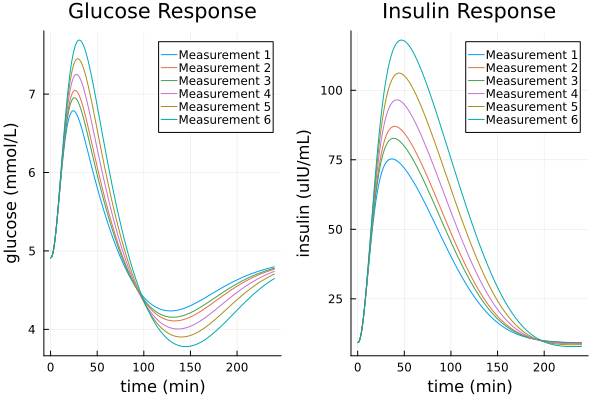

In [52]:
# load the training progressions
# training_progressions = JLD2.load("Metadata/Training_progressions.jld2")["training_progressions"];

# select the first progression
progression =  training_progressions[2]
model = progression.patient.EDES

# plot the meal response
PlotMealResponse(model, progression.parameter_names, progression.parameter_values)



In [ ]:
LocalSensitivityAnalysis(progression)

### Make for every patient a synthetic progression
